![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Advanced Predictive Modeling with Python 
## Session #2: Ensembles of Classifiers
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

### Schedule for Today

|Start Time | Session |
|-----------|---------|
|8:30am     | Check In|
|9:00am     | **Feature Engineering** |
|10:30am    | Coffee & Bagels|
|10:45am    | **Ensembling** |
|12:30pm    | End|

### Goals of this Lesson
- Feature transformations
    - Std. Normal Scaling
    - Log Transform
    - Domain-Specific Transform
    
- Principal Component Analysis (PCA)
    - Model and Learning
    - PCA for Images
    - PCA for Visualization

### References 
- Chapter 14 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf)
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's documentation on data preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- [SciKit-Learn's documentation on dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [79]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import cPickle as cp
%matplotlib inline

Again we need functions for shuffling the data and calculating classification errrors.

In [80]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

### 0.1  Load the dataset of paintings
We are going to use the Bob Ross paintings dataset throughout this session.  Let's load the PCA'd version we saved during the first session...

In [81]:
from sklearn.decomposition import PCA

# load the 403 x 360,000 matrix
br_paintings = np.load(open('../data/bob_ross/bob_ross_paintings.npy','rb'))

# perform PCA again
pca = PCA(n_components=400)
start_time = time.time()
pca_paintings = pca.fit_transform(br_paintings)
end_time = time.time()

# remove the br_paintings from memory
br_paintings = None

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(reduced_paintings.shape)

Training took a total of 22.50 seconds.
Preserved percentage of original variance: 99.99%
Dataset is now of size: 403 x 400


We want to formulate a binary classification problem.  In the data folder there's a file that has labels denoting what is in each painting (tree, mountain, etc.).  Let's load it...

In [82]:
br_labels_data = pd.read_csv('../data/bob_ross/elements-by-episode.csv')
br_labels_data.head()

,EPISODE,TITLE,APPLE_FRAME,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,...,TOMB_FRAME,TREE,TREES,TRIPLE_FRAME,WATERFALL,WAVES,WINDMILL,WINDOW_FRAME,WINTER,WOOD_FRAMED
0,S01E01,a walk in the woods,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
1,S01E02,mt. mckinley,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,S01E03,ebony sunset,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,S01E04,winter mist,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
4,S01E05,quiet stream,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


Let's make the two classes 1 = 'painting contains hill or mountain', 0 = 'doesn't contain hill/mountain': 

Contains mountain?: True


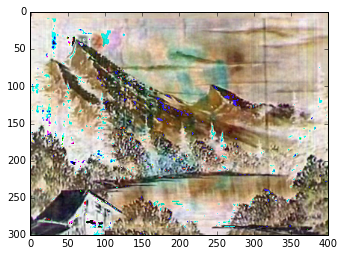

Contains mountain?: False


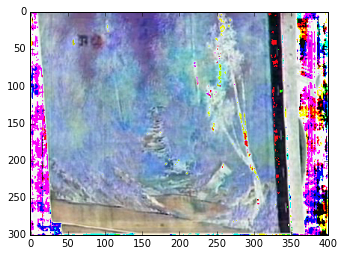

In [89]:
labels = (br_labels_data['HILLS'] + br_labels_data['MOUNTAIN'] + br_labels_data['MOUNTAINS'] + br_labels_data['SNOWY_MOUNTAIN'] > 0).astype('int').tolist()

print "Contains mountain?: "+str(bool(labels[5]))
recon_img = pca.inverse_transform(pca_paintings[5,:])
plt.imshow(np.reshape(recon_img, (300, 400, 3)))
plt.show()

print "Contains mountain?: "+str(bool(labels[0]))
recon_img = pca.inverse_transform(pca_paintings[0,:])
plt.imshow(np.reshape(recon_img, (300, 400, 3)))
plt.show()

Make training and test split...

In [106]:
# set the random number generator for reproducability
np.random.seed(123)

# shuffle data
N = pca_paintings.shape[0]
shuffle_in_unison(pca_paintings, labels)

# split into train and test sets
train_features = pca_paintings[:int(.8*N), :]
test_features = pca_paintings[int(.8*N):, :]
train_labels = labels[:int(.8*N)]
test_labels = labels[int(.8*N):]

### 0.2  Run a baseline classifier
In order to see the improvements that ensembling provides, let's train a baseline logistic regression classifier for later comparison.

In [107]:
from sklearn import linear_model

# initialize and train a logistic regression model
lm = linear_model.LogisticRegression()
lm.fit(train_features, train_labels)

# compute error on training data
predictions = lm.predict(test_features)
test_error_rate = calc_classification_error(predictions, test_labels)

print "Classification error on test set: %.2f%%" %(test_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %((sum(test_labels)*100.)/len(test_labels))

Classification error on test set: 33.33%
Baseline Error: 43.21%


## 1.  The Bias-Variance Tradeoff

When faced with an important decision, its common to ask multiple people for their advice.  Why should a classification decision be any different?  If computer power is not a limiting factor--which is usually the case--why not train multiple classifiers and combine their predictions?  This is exactly what *ensembling* classifiers does.  In this section we'll cover three methods for combining classifiers: bagging, averaging, and stacking.  But first, let's examine why one classifier is usually not enough.  It can be formalized as a tradeoff between *bias* and *variance*.  

Recall the squared loss function: $$\mathcal{L} = \sum_{i}^{N} (y_{i} - f(\mathbf{x}_{i}))^{2}. $$  This loss is over a particular training set {$\mathbf{X}, \mathbf{y}$} but we are really interested in the loss over all possible datasets we could have observed, $\{\mathbf{X}, \mathbf{y}\} \sim p(\mathcal{D})$: $$\mathbb{E}_{p(\mathcal{D})}[\mathcal{L}] = \mathbb{E}_{p(\mathcal{D})}[(y_{i} - f(\mathbf{x}_{i}))^{2}]. $$  After some [algebraic manipulations](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation), we can re-write the expected loss as $$\mathbb{E}_{p(\mathcal{D})}[\mathcal{L}] = (f^{*}(\mathbf{x}_{i}) - \mathbb{E}[f(\mathbf{x}_{i})])^{2} + \text{Var}[f(\mathbf{x}_{i})] + \text{constant (error)}. $$  The first term, $(f^{*}(\mathbf{x}_{i}) - \mathbb{E}[f(\mathbf{x}_{i})])^{2}$, is the squared difference between the expected value of the classifier $f$ and the **perfect, true** classifier $f^{*}$.  This difference is known as the *bias* of a classifier.  For instance, a linear model has a strong bias since its functional form is rather simple (unless the optimial classifier is also a linear function).  The second term, $\text{Var}[f(\mathbf{x}_{i})]$, is the variance of our classifier.  Basically, this term captures the variability in outputs.  The main point is that if a classifier has *low* bias, meaning it is a very powerful function, then it will usually have high *variance* since this power allows it to generate a wide range of outputs.  And vice versa.  What I just said can be represented graphically as 
![bias_variance_pic](../graphics/bias-variance.png)
Ensembling classifiers all but always produces better performance because it **reduces variance without incurring bias**.

## 2.  Bootstrap Aggregating ('Bagging')
In section 1, when I mentioned using multiple classifiers, you probably thought I was talking about training and combining several different kinds of classifiers.  We will do that.  But first we'll discuss something simpler: training the same classifier on multiple datasets.  

### 2.1 Bootstrap Resampling
We can squeeze 'extra robustness' out of our dataset by doing the following simple procedure.  Whereas our original dataset is {}

In [122]:
### function for bootstrap resampling
def bootstrap_resample(data, n_resamples):
    N = data.shape[0]
    idxs = np.arange(N)
    resampled_idxs = np.random.choice(idxs, size=(N,n_resamples), replace=True)
    boot_samps = []
    for i in xrange(n_resamples):
        boot_samps.append(data[resampled_idxs[:,i],:])
    return boot_samps

data = np.random.uniform(size=(7,3))
print bootstrap_resample(data, 2)


[array([[ 0.36291164,  0.1588661 ,  0.22092845],
       [ 0.55293146,  0.69045392,  0.27758594],
       [ 0.4297222 ,  0.12449379,  0.24328085],
       [ 0.66767244,  0.16090518,  0.51856531],
       [ 0.55261806,  0.37980344,  0.02944013],
       [ 0.12214056,  0.88351529,  0.55459527],
       [ 0.55293146,  0.69045392,  0.27758594]]), array([[ 0.36291164,  0.1588661 ,  0.22092845],
       [ 0.55261806,  0.37980344,  0.02944013],
       [ 0.4297222 ,  0.12449379,  0.24328085],
       [ 0.36291164,  0.1588661 ,  0.22092845],
       [ 0.55293146,  0.69045392,  0.27758594],
       [ 0.4297222 ,  0.12449379,  0.24328085],
       [ 0.66767244,  0.16090518,  0.51856531]])]
